In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection  import RandomizedSearchCV,StratifiedKFold
from tqdm import tqdm
import datetime
from joblib import dump,load
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [2]:
Paths=['/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/Train-1542865627584.csv',
'/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/Train_Beneficiarydata-1542865627584.csv',
'/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/Train_Inpatientdata-1542865627584.csv',
'/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/Train_Outpatientdata-1542865627584.csv']

In [3]:
def PredictionFunc(X):
  '''X is the list of paths for data files
  and returns the predictions 'Y'.'''

  # reading all files
  df_provider=pd.read_csv(X[0])
  df_benefeciary=pd.read_csv(X[1])
  df_inpatient=pd.read_csv(X[2])
  df_outpatient=pd.read_csv(X[3])
  print("\nReaded all csv's.")
  
  ## AGE
  # creating a timestamp for date '2009-12-01' to measure the age of live benefeciaries from this date
  x = pd.to_datetime('2009-12-01',format='%Y-%m-%d')
  #print(type(x))
  # creating a series age with all age ewual to zero 
  df_benefeciary['Age']=0

  # Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)
  df_benefeciary['DOB'] = pd.to_datetime(df_benefeciary['DOB'] , format = '%Y-%m-%d')
  df_benefeciary['DOD'] = pd.to_datetime(df_benefeciary['DOD'],format = '%Y-%m-%d',errors='ignore')

  # how to calculate age feauture:- filled age column with age calculated using DOB and DOD for dead benefeciaries and
  # for live benefeciary age calculated using date '2009-12-01'.
  for i in range(len(df_benefeciary)):
    if type(df_benefeciary['DOD'].iloc[i])==type(x):
      df_benefeciary['Age'].iloc[i]=round(((df_benefeciary['DOD'].iloc[i]- df_benefeciary['DOB'].iloc[i])/365).days)
    else:
      df_benefeciary['Age'].iloc[i]=round(((x- df_benefeciary['DOB'].iloc[i])/365).days)
  
  print('\nAdded Age feature.')

  ## COMBINING df_inpatient AND  df_outpatient 
  df_patient_data=pd.merge(df_outpatient,df_inpatient,how='outer')

  #joining df_patient_data and df_beneficiary using BeneID 
  Train_AllPatient_data=pd.merge(df_patient_data,df_benefeciary,left_on='BeneID',right_on='BeneID',how='inner')
  
  # Total data (provider data + benefeciary data + inpatitent data + outpatient data )
  Train_ProviderWithPatient_data=pd.merge(df_provider,Train_AllPatient_data,on='Provider',how= 'inner')
  print('\nshape of Train_ProviderWithPatient_data:',Train_ProviderWithPatient_data.shape)

  #0 1 Encoding of RenalDiseaseIndicator
  Train_ProviderWithPatient_data['RenalDiseaseIndicator']=Train_ProviderWithPatient_data['RenalDiseaseIndicator'].map({'Y':1,'0':0})

  #0 1 Encoding of chronic
  # convet 2 to 0 and 1 to 1
  Train_ProviderWithPatient_data['ChronicCond_Alzheimer']=Train_ProviderWithPatient_data['ChronicCond_Alzheimer'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Heartfailure']=Train_ProviderWithPatient_data['ChronicCond_Heartfailure'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_KidneyDisease']=Train_ProviderWithPatient_data['ChronicCond_KidneyDisease'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Cancer']=Train_ProviderWithPatient_data['ChronicCond_Cancer'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_ObstrPulmonary']=Train_ProviderWithPatient_data['ChronicCond_ObstrPulmonary'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Depression']=Train_ProviderWithPatient_data['ChronicCond_Depression'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Diabetes']=Train_ProviderWithPatient_data['ChronicCond_Diabetes'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_IschemicHeart']=Train_ProviderWithPatient_data['ChronicCond_IschemicHeart'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Osteoporasis']=Train_ProviderWithPatient_data['ChronicCond_Osteoporasis'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_rheumatoidarthritis']=Train_ProviderWithPatient_data['ChronicCond_rheumatoidarthritis'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_stroke']=Train_ProviderWithPatient_data['ChronicCond_stroke'].map({2:0,1:1})
  print('\n0 1 Encoding of chronic and RenalDiseaseIndicator features.')

  #dividing numerical and categorical featues into two list so further procassing using these two list will be helpful.
  ListOfCatFeat=['BeneID','ClaimID', 'AttendingPhysician','OperatingPhysician',
  'OtherPhysician','ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3',
  'ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7',
  'ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10','ClmProcedureCode_1',
  'ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmAdmitDiagnosisCode',
  'ClmAdmitDiagnosisCode','DiagnosisGroupCode','Gender','Race','RenalDiseaseIndicator',
  'State','County']

  #WhetherDead
  #if date of DOD is not present then that patient is dead
  Train_ProviderWithPatient_data['WhetherDead']= 0
  Train_ProviderWithPatient_data.loc[Train_ProviderWithPatient_data.DOD.notnull(),'WhetherDead']=1
  print('\nAdded WhetherDead feature.')

  #physician present or not
  #list of feature names+_pr ,these feature tells about physician present or not
  list_ClmDiagnosisCodes_pr=[i+'_pr' for i in Train_ProviderWithPatient_data.columns if 'Physician' in i]
  # fillna with 0 ,means if physicain not present then 0 else 1
  Train_ProviderWithPatient_data[list_ClmDiagnosisCodes_pr] =np.where(Train_ProviderWithPatient_data[['AttendingPhysician',
                                                                                                    'OperatingPhysician', 
                                                                                                    'OtherPhysician']].isnull(), 0, 1)
  print('\nAdded physician present or not features.')

  #function for counting unique values in rows.
  def uniq(df):
    ''' this function  takes features and count unique values in row and 
    return the count of uniqe values '''
    return ([len(set([i for i in x[pd.notnull(x)]])) for x in df.values])

  #one physician could work for several roles for one patient so we need to calculate number of unique physicians per patitent
  #Number of physician per patient.
  Train_ProviderWithPatient_data['NumberOFPhysicians']=uniq(Train_ProviderWithPatient_data[['AttendingPhysician',
                                                                                          'OperatingPhysician', 
                                                                                          'OtherPhysician']])
  print('\nAdded NumberOFPhysicians feature.')
  # feature for count of unique physician
  #Train_ProviderWithPatient_data['NumberOFPhysicians']
  #print('Train_ProviderWithPatient_data:',Train_ProviderWithPatient_data.shape)

  # number of ChronicCond featues
  list_ChronicCond=[i for i in Train_ProviderWithPatient_data.columns if 'ChronicCond' in i] # list of chronic_cond features
  #print('len(list_ChronicCond):',len(list_ChronicCond))
  #add this feature
  Train_ProviderWithPatient_data['NumberOFChronic']=Train_ProviderWithPatient_data[list_ChronicCond].sum(axis=1)
  print('\nAdded NumberOFChronic feature.')

  #count of dignosis
  type_of_feature_for_count='DiagnosisCode'
  DignosisCodeFeats=[i for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  #for unique dignosis code per patient
  Train_ProviderWithPatient_data['uniqclaims']=uniq(Train_ProviderWithPatient_data[DignosisCodeFeats])

  #for dignosis_count(count if any code repeated for data point)
  df=Train_ProviderWithPatient_data
  #list of feature names+_pr ,these feature tells about ClmDiagnosisCode present or not
  DignosisCodeFeats_pr=[i+'_pr' for i in df.columns if type_of_feature_for_count in i]
  # fillna with 0 ,means if ClmDiagnosisCode not present then 0 else 1
  df[DignosisCodeFeats_pr] =np.where(df[DignosisCodeFeats].isnull(), 0, 1)
  # empty feature for storing count of ClmDiagnosisCode
  df['NumOFClmDiagnosisCode']=0
  # adding count of ClmDiagnosisCode
  for i in DignosisCodeFeats_pr:
    df['NumOFClmDiagnosisCode'] +=df[i]
  
  #if any Dignosiscode is repeated for a patient(in datapoint) or not, this will be captured by ExtraClaims feature
  df['ExtraClaims']=df['NumOFClmDiagnosisCode']-Train_ProviderWithPatient_data['uniqclaims']

  print('\nAdded number of uniq claims and total number of claims for provider')

  #Count procedure_count
  type_of_feature_for_count='ProcedureCode'
  ProcedureCode_feats=[i for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  #for unique Procedure codes per patient
  Train_ProviderWithPatient_data['UniqProcedures']=uniq(Train_ProviderWithPatient_data[ProcedureCode_feats])
  #for ProcedureCode_count

  #list of feature names+_pr ,these feature tells about ProcedureCode present or not
  ProcedureCodeFeat_pr=[i+'_pr' for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  # fillna with 0 ,means if ProcedureCode not present then 0 else 1
  Train_ProviderWithPatient_data[ProcedureCodeFeat_pr] =np.where(Train_ProviderWithPatient_data[ProcedureCode_feats].isnull(), 0, 1)
  # empty feature for storing count of ProcedureCode
  Train_ProviderWithPatient_data['NumOfProcedureCode']=0
  # adding count of ProcedureCode
  for i in ProcedureCodeFeat_pr:
    Train_ProviderWithPatient_data['NumOfProcedureCode'] +=Train_ProviderWithPatient_data[i]

  print('\nAdded number of uniq ProcedureCode and total number of ProcedureCode for provider')

  ##DATE TO DAYS CREATED days_to_process_claim,Admit_days FEATURES
  # Using admission date and discharge date create feature admit days 
  Train_ProviderWithPatient_data['AdmissionDt'] = pd.to_datetime(Train_ProviderWithPatient_data['AdmissionDt'] , format = '%Y-%m-%d')
  Train_ProviderWithPatient_data['DischargeDt'] = pd.to_datetime(Train_ProviderWithPatient_data['DischargeDt'],format = '%Y-%m-%d',errors='ignore')
  Train_ProviderWithPatient_data['Admit_days'] = round(((Train_ProviderWithPatient_data['DischargeDt'] - Train_ProviderWithPatient_data['AdmissionDt']).dt.days))
  Train_ProviderWithPatient_data['Admit_days']=Train_ProviderWithPatient_data['Admit_days'].fillna(0)

  # Add feature days_to_process_claim which says about how many days are taken to process the claim
  # using claimEndDate-ClaimStartDate
  Train_ProviderWithPatient_data['ClaimStartDt'] = pd.to_datetime(Train_ProviderWithPatient_data['ClaimStartDt'] , format = '%Y-%m-%d')
  Train_ProviderWithPatient_data['ClaimEndDt'] = pd.to_datetime(Train_ProviderWithPatient_data['ClaimEndDt'],format = '%Y-%m-%d',errors='ignore')
  Train_ProviderWithPatient_data['DaysToProcessClaim'] = round(((Train_ProviderWithPatient_data['ClaimEndDt'] - Train_ProviderWithPatient_data['ClaimStartDt']).dt.days))

  print('\nAdded Admit_days,DaysToProcessClaim features. ')

  #Interaction Features
  ##Numerical feature interaction
  #Frauds have more deductible amount
  #frauda trying to get more InscClaimAmtReimbursed
  # interaction of these two will help
  Train_ProviderWithPatient_data['InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['InscClaimAmtReimbursed']+Train_ProviderWithPatient_data['IPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['InscClaimAmtReimbursed']+Train_ProviderWithPatient_data['OPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['IPAnnualReimbursementAmt']+Train_ProviderWithPatient_data['OPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['DeductibleAmtPaidPlusIPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['DeductibleAmtPaid']+Train_ProviderWithPatient_data['IPAnnualDeductibleAmt']
  Train_ProviderWithPatient_data['DeductibleAmtPaidPlusOPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['DeductibleAmtPaid']+Train_ProviderWithPatient_data['OPAnnualDeductibleAmt']
  Train_ProviderWithPatient_data['IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['IPAnnualDeductibleAmt']+Train_ProviderWithPatient_data['OPAnnualDeductibleAmt']
  print('\nusing feature interacton of numerical features I added 6 features')

  ##categorical feature interaction
  Train_ProviderWithPatient_data['Provider_BeneID']=Train_ProviderWithPatient_data['Provider']+'_'+Train_ProviderWithPatient_data['BeneID']
  Train_ProviderWithPatient_data['Provider_AttendingPhysician']=Train_ProviderWithPatient_data['Provider']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  Train_ProviderWithPatient_data['BeneID_AttendingPhysician']=Train_ProviderWithPatient_data['BeneID']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  Train_ProviderWithPatient_data['ClmDiagnosisCode_1_AttendingPhysician']=Train_ProviderWithPatient_data['ClmDiagnosisCode_1']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  print('\nusing feature interaction of categorical features I added 4 features')

  #DiagnosisGroupCode says about patitient was hospitalixed or not.
  Train_ProviderWithPatient_data['1_0DiagnosisGroupCode']=np.where(Train_ProviderWithPatient_data.DiagnosisGroupCode.notnull(), 1, 0)

  #Creating new dataframe data which will be used for grouping using provider and finding min,max, sum based features .
  data=Train_ProviderWithPatient_data[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt',
       
       ]]
  #fill na with 0
  data=data.fillna(0)

  df1=data.groupby(['Provider'], as_index = False)[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].sum()
  print('\nshape of df using sum of values:',df1.shape)

  DfMaxMoney=data.groupby(['Provider'], as_index = False)[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].max()
  print('\nshape of df using max values:',DfMaxMoney.shape)

  # beneID will be number of unique beneID's for a provider and 
  # ClaimID will be number of unique ClaimID's for a provider 
  df2 = Train_ProviderWithPatient_data[['BeneID', 'ClaimID']].groupby(Train_ProviderWithPatient_data['Provider']).nunique().reset_index()
  #df2 will contain above two features

  # Calculate mean features df
  df3 = data.groupby(['Provider'], as_index = False)[['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                      'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
                                                      'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
                                                      'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
                                                      'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
                                                      'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
                                                      'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
                                                      'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].mean()
  print('\nshape of df using mean of money features:',df3.shape)
  #conveting column names to feature_name+mean
  df3.columns=['Provider']+[i+'Mean' for i in ['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
  'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
  'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
  'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
  'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
  'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
  'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
  'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']]

  ### Combine all the different features into single df for modeling
  df = df2.merge(df1, on='Provider', how='left').merge(df3, on='Provider', how='left')\
  .merge(DfMaxMoney,on='Provider',how='left')#.merge(CountleastFreqCat_Df,on='Provider',how='left')
  print('\nShape of Df containing combination of all features:',df.shape)

  # providing targets to all providers
  df=df.merge(df_provider,on='Provider',how='left')
  # target of data 
  target=df['PotentialFraud'].map({'Yes':1,'No':0})
  # data
  X=df.drop(['PotentialFraud','Provider'],axis=1)
  minmax=load('/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/models/MinMaxScaler.joblib')
  X=minmax.transform(X)
  print('\nscaling Done')
  clf=load('/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/models/DecisionTreeClassifier.joblib')
  prediction=clf.predict(X)
  print('\nPredictions Done')
  return prediction

In [4]:
Y=PredictionFunc(Paths)


Readed all csv's.

Added Age feature.

shape of Train_ProviderWithPatient_data: (558211, 56)

0 1 Encoding of chronic and RenalDiseaseIndicator features.

Added WhetherDead feature.

Added physician present or not features.

Added NumberOFPhysicians feature.

Added NumberOFChronic feature.

Added number of uniq claims and total number of claims for provider

Added number of uniq ProcedureCode and total number of ProcedureCode for provider

Added Admit_days,DaysToProcessClaim features. 

using feature interacton of numerical features I added 6 features

using feature interaction of categorical features I added 4 features

shape of df using sum of values: (5410, 38)

shape of df using max values: (5410, 38)

shape of df using mean of money features: (5410, 12)

Shape of Df containing combination of all features: (5410, 88)

scaling Done

Predictions Done


In [6]:
def performance(X,Y):
  '''This function takes X is the list of paths for data files 
  Y is actual targets,
  returns the F1 score and confusion matrix,precision matrix,recall matrix.'''

  # reading all files
  df_provider=pd.read_csv(X[0])
  df_benefeciary=pd.read_csv(X[1])
  df_inpatient=pd.read_csv(X[2])
  df_outpatient=pd.read_csv(X[3])
  print("\nReaded all csv's.")
  
  ## AGE
  # creating a timestamp for date '2009-12-01' to measure the age of live benefeciaries from this date
  x = pd.to_datetime('2009-12-01',format='%Y-%m-%d')
  #print(type(x))
  # creating a series age with all age ewual to zero 
  df_benefeciary['Age']=0

  # Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)
  df_benefeciary['DOB'] = pd.to_datetime(df_benefeciary['DOB'] , format = '%Y-%m-%d')
  df_benefeciary['DOD'] = pd.to_datetime(df_benefeciary['DOD'],format = '%Y-%m-%d',errors='ignore')

  # how to calculate age feauture:- filled age column with age calculated using DOB and DOD for dead benefeciaries and
  # for live benefeciary age calculated using date '2009-12-01'.
  for i in range(len(df_benefeciary)):
    if type(df_benefeciary['DOD'].iloc[i])==type(x):
      df_benefeciary['Age'].iloc[i]=round(((df_benefeciary['DOD'].iloc[i]- df_benefeciary['DOB'].iloc[i])/365).days)
    else:
      df_benefeciary['Age'].iloc[i]=round(((x- df_benefeciary['DOB'].iloc[i])/365).days)
  
  print('\nAdded Age feature.')

  ## COMBINING df_inpatient AND  df_outpatient 
  df_patient_data=pd.merge(df_outpatient,df_inpatient,how='outer')

  #joining df_patient_data and df_beneficiary using BeneID 
  Train_AllPatient_data=pd.merge(df_patient_data,df_benefeciary,left_on='BeneID',right_on='BeneID',how='inner')
  
  # Total data (provider data + benefeciary data + inpatitent data + outpatient data )
  Train_ProviderWithPatient_data=pd.merge(df_provider,Train_AllPatient_data,on='Provider',how= 'inner')
  print('\nshape of Train_ProviderWithPatient_data:',Train_ProviderWithPatient_data.shape)

  #0 1 Encoding of RenalDiseaseIndicator
  Train_ProviderWithPatient_data['RenalDiseaseIndicator']=Train_ProviderWithPatient_data['RenalDiseaseIndicator'].map({'Y':1,'0':0})

  #0 1 Encoding of chronic
  # convet 2 to 0 and 1 to 1
  Train_ProviderWithPatient_data['ChronicCond_Alzheimer']=Train_ProviderWithPatient_data['ChronicCond_Alzheimer'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Heartfailure']=Train_ProviderWithPatient_data['ChronicCond_Heartfailure'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_KidneyDisease']=Train_ProviderWithPatient_data['ChronicCond_KidneyDisease'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Cancer']=Train_ProviderWithPatient_data['ChronicCond_Cancer'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_ObstrPulmonary']=Train_ProviderWithPatient_data['ChronicCond_ObstrPulmonary'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Depression']=Train_ProviderWithPatient_data['ChronicCond_Depression'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Diabetes']=Train_ProviderWithPatient_data['ChronicCond_Diabetes'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_IschemicHeart']=Train_ProviderWithPatient_data['ChronicCond_IschemicHeart'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_Osteoporasis']=Train_ProviderWithPatient_data['ChronicCond_Osteoporasis'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_rheumatoidarthritis']=Train_ProviderWithPatient_data['ChronicCond_rheumatoidarthritis'].map({2:0,1:1})
  Train_ProviderWithPatient_data['ChronicCond_stroke']=Train_ProviderWithPatient_data['ChronicCond_stroke'].map({2:0,1:1})
  print('\n0 1 Encoding of chronic and RenalDiseaseIndicator features.')

  #dividing numerical and categorical featues into two list so further procassing using these two list will be helpful.
  ListOfCatFeat=['BeneID','ClaimID', 'AttendingPhysician','OperatingPhysician',
  'OtherPhysician','ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3',
  'ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7',
  'ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10','ClmProcedureCode_1',
  'ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmAdmitDiagnosisCode',
  'ClmAdmitDiagnosisCode','DiagnosisGroupCode','Gender','Race','RenalDiseaseIndicator',
  'State','County']

  #WhetherDead
  #if date of DOD is not present then that patient is dead
  Train_ProviderWithPatient_data['WhetherDead']= 0
  Train_ProviderWithPatient_data.loc[Train_ProviderWithPatient_data.DOD.notnull(),'WhetherDead']=1
  print('\nAdded WhetherDead feature.')

  #physician present or not
  #list of feature names+_pr ,these feature tells about physician present or not
  list_ClmDiagnosisCodes_pr=[i+'_pr' for i in Train_ProviderWithPatient_data.columns if 'Physician' in i]
  # fillna with 0 ,means if physicain not present then 0 else 1
  Train_ProviderWithPatient_data[list_ClmDiagnosisCodes_pr] =np.where(Train_ProviderWithPatient_data[['AttendingPhysician',
                                                                                                    'OperatingPhysician', 
                                                                                                    'OtherPhysician']].isnull(), 0, 1)
  print('\nAdded physician present or not features.')

  #function for counting unique values in rows.
  def uniq(df):
    ''' this function  takes features and count unique values in row and 
    return the count of uniqe values '''
    return ([len(set([i for i in x[pd.notnull(x)]])) for x in df.values])

  #one physician could work for several roles for one patient so we need to calculate number of unique physicians per patitent
  #Number of physician per patient.
  Train_ProviderWithPatient_data['NumberOFPhysicians']=uniq(Train_ProviderWithPatient_data[['AttendingPhysician',
                                                                                          'OperatingPhysician', 
                                                                                          'OtherPhysician']])
  print('\nAdded NumberOFPhysicians feature.')
  # feature for count of unique physician
  #Train_ProviderWithPatient_data['NumberOFPhysicians']
  #print('Train_ProviderWithPatient_data:',Train_ProviderWithPatient_data.shape)

  # number of ChronicCond featues
  list_ChronicCond=[i for i in Train_ProviderWithPatient_data.columns if 'ChronicCond' in i] # list of chronic_cond features
  #print('len(list_ChronicCond):',len(list_ChronicCond))
  #add this feature
  Train_ProviderWithPatient_data['NumberOFChronic']=Train_ProviderWithPatient_data[list_ChronicCond].sum(axis=1)
  print('\nAdded NumberOFChronic feature.')

  #count of dignosis
  type_of_feature_for_count='DiagnosisCode'
  DignosisCodeFeats=[i for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  #for unique dignosis code per patient
  Train_ProviderWithPatient_data['uniqclaims']=uniq(Train_ProviderWithPatient_data[DignosisCodeFeats])

  #for dignosis_count(count if any code repeated for data point)
  df=Train_ProviderWithPatient_data
  #list of feature names+_pr ,these feature tells about ClmDiagnosisCode present or not
  DignosisCodeFeats_pr=[i+'_pr' for i in df.columns if type_of_feature_for_count in i]
  # fillna with 0 ,means if ClmDiagnosisCode not present then 0 else 1
  df[DignosisCodeFeats_pr] =np.where(df[DignosisCodeFeats].isnull(), 0, 1)
  # empty feature for storing count of ClmDiagnosisCode
  df['NumOFClmDiagnosisCode']=0
  # adding count of ClmDiagnosisCode
  for i in DignosisCodeFeats_pr:
    df['NumOFClmDiagnosisCode'] +=df[i]
  
  #if any Dignosiscode is repeated for a patient(in datapoint) or not, this will be captured by ExtraClaims feature
  df['ExtraClaims']=df['NumOFClmDiagnosisCode']-Train_ProviderWithPatient_data['uniqclaims']

  print('\nAdded number of uniq claims and total number of claims for provider')

  #Count procedure_count
  type_of_feature_for_count='ProcedureCode'
  ProcedureCode_feats=[i for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  #for unique Procedure codes per patient
  Train_ProviderWithPatient_data['UniqProcedures']=uniq(Train_ProviderWithPatient_data[ProcedureCode_feats])
  #for ProcedureCode_count

  #list of feature names+_pr ,these feature tells about ProcedureCode present or not
  ProcedureCodeFeat_pr=[i+'_pr' for i in Train_ProviderWithPatient_data.columns if type_of_feature_for_count in i]
  # fillna with 0 ,means if ProcedureCode not present then 0 else 1
  Train_ProviderWithPatient_data[ProcedureCodeFeat_pr] =np.where(Train_ProviderWithPatient_data[ProcedureCode_feats].isnull(), 0, 1)
  # empty feature for storing count of ProcedureCode
  Train_ProviderWithPatient_data['NumOfProcedureCode']=0
  # adding count of ProcedureCode
  for i in ProcedureCodeFeat_pr:
    Train_ProviderWithPatient_data['NumOfProcedureCode'] +=Train_ProviderWithPatient_data[i]

  print('\nAdded number of uniq ProcedureCode and total number of ProcedureCode for provider')

  ##DATE TO DAYS CREATED days_to_process_claim,Admit_days FEATURES
  # Using admission date and discharge date create feature admit days 
  Train_ProviderWithPatient_data['AdmissionDt'] = pd.to_datetime(Train_ProviderWithPatient_data['AdmissionDt'] , format = '%Y-%m-%d')
  Train_ProviderWithPatient_data['DischargeDt'] = pd.to_datetime(Train_ProviderWithPatient_data['DischargeDt'],format = '%Y-%m-%d',errors='ignore')
  Train_ProviderWithPatient_data['Admit_days'] = round(((Train_ProviderWithPatient_data['DischargeDt'] - Train_ProviderWithPatient_data['AdmissionDt']).dt.days))
  Train_ProviderWithPatient_data['Admit_days']=Train_ProviderWithPatient_data['Admit_days'].fillna(0)

  # Add feature days_to_process_claim which says about how many days are taken to process the claim
  # using claimEndDate-ClaimStartDate
  Train_ProviderWithPatient_data['ClaimStartDt'] = pd.to_datetime(Train_ProviderWithPatient_data['ClaimStartDt'] , format = '%Y-%m-%d')
  Train_ProviderWithPatient_data['ClaimEndDt'] = pd.to_datetime(Train_ProviderWithPatient_data['ClaimEndDt'],format = '%Y-%m-%d',errors='ignore')
  Train_ProviderWithPatient_data['DaysToProcessClaim'] = round(((Train_ProviderWithPatient_data['ClaimEndDt'] - Train_ProviderWithPatient_data['ClaimStartDt']).dt.days))

  print('\nAdded Admit_days,DaysToProcessClaim features. ')

  #Interaction Features
  ##Numerical feature interaction
  #Frauds have more deductible amount
  #frauda trying to get more InscClaimAmtReimbursed
  # interaction of these two will help
  Train_ProviderWithPatient_data['InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['InscClaimAmtReimbursed']+Train_ProviderWithPatient_data['IPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['InscClaimAmtReimbursed']+Train_ProviderWithPatient_data['OPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt']=Train_ProviderWithPatient_data['IPAnnualReimbursementAmt']+Train_ProviderWithPatient_data['OPAnnualReimbursementAmt']
  Train_ProviderWithPatient_data['DeductibleAmtPaidPlusIPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['DeductibleAmtPaid']+Train_ProviderWithPatient_data['IPAnnualDeductibleAmt']
  Train_ProviderWithPatient_data['DeductibleAmtPaidPlusOPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['DeductibleAmtPaid']+Train_ProviderWithPatient_data['OPAnnualDeductibleAmt']
  Train_ProviderWithPatient_data['IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']=Train_ProviderWithPatient_data['IPAnnualDeductibleAmt']+Train_ProviderWithPatient_data['OPAnnualDeductibleAmt']
  print('\nusing feature interacton of numerical features I added 6 features')

  ##categorical feature interaction
  Train_ProviderWithPatient_data['Provider_BeneID']=Train_ProviderWithPatient_data['Provider']+'_'+Train_ProviderWithPatient_data['BeneID']
  Train_ProviderWithPatient_data['Provider_AttendingPhysician']=Train_ProviderWithPatient_data['Provider']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  Train_ProviderWithPatient_data['BeneID_AttendingPhysician']=Train_ProviderWithPatient_data['BeneID']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  Train_ProviderWithPatient_data['ClmDiagnosisCode_1_AttendingPhysician']=Train_ProviderWithPatient_data['ClmDiagnosisCode_1']+'_'+Train_ProviderWithPatient_data['AttendingPhysician']
  print('\nusing feature interaction of categorical features I added 4 features')

  #DiagnosisGroupCode says about patitient was hospitalixed or not.
  Train_ProviderWithPatient_data['1_0DiagnosisGroupCode']=np.where(Train_ProviderWithPatient_data.DiagnosisGroupCode.notnull(), 1, 0)

  #Creating new dataframe data which will be used for grouping using provider and finding min,max, sum based features .
  data=Train_ProviderWithPatient_data[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt',
       
       ]]
  #fill na with 0
  data=data.fillna(0)

  df1=data.groupby(['Provider'], as_index = False)[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].sum()
  print('\nshape of df using sum of values:',df1.shape)

  DfMaxMoney=data.groupby(['Provider'], as_index = False)[[ 'Provider','InscClaimAmtReimbursed', 
       'DeductibleAmtPaid',
       'RenalDiseaseIndicator', 'County',
       'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'WhetherDead', 'NumberOFPhysicians','NumberOFChronic', 'uniqclaims', 
       'NumOFClmDiagnosisCode', 'ExtraClaims', 'UniqProcedures',
       'NumOfProcedureCode',
       'Admit_days', 'DaysToProcessClaim', '1_0DiagnosisGroupCode',
       'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
       'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
       'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
       'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
       'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].max()
  print('\nshape of df using max values:',DfMaxMoney.shape)

  # beneID will be number of unique beneID's for a provider and 
  # ClaimID will be number of unique ClaimID's for a provider 
  df2 = Train_ProviderWithPatient_data[['BeneID', 'ClaimID']].groupby(Train_ProviderWithPatient_data['Provider']).nunique().reset_index()
  #df2 will contain above two features

  # Calculate mean features df
  df3 = data.groupby(['Provider'], as_index = False)[['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                      'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
                                                      'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
                                                      'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
                                                      'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
                                                      'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
                                                      'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
                                                      'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']].mean()
  print('\nshape of df using mean of money features:',df3.shape)
  #conveting column names to feature_name+mean
  df3.columns=['Provider']+[i+'Mean' for i in ['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
  'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
  'InscClaimAmtReimbursedPlusIPAnnualReimbursementAmt',
  'InscClaimAmtReimbursedPlusOPAnnualReimbursementAmt',
  'IPAnnualReimbursementAmtPlusOPAnnualReimbursementAmt',
  'DeductibleAmtPaidPlusIPAnnualDeductibleAmt',
  'DeductibleAmtPaidPlusOPAnnualDeductibleAmt',
  'IPAnnualDeductibleAmtPlusOPAnnualDeductibleAmt']]

  ### Combine all the different features into single df for modeling
  df = df2.merge(df1, on='Provider', how='left').merge(df3, on='Provider', how='left')\
  .merge(DfMaxMoney,on='Provider',how='left')#.merge(CountleastFreqCat_Df,on='Provider',how='left')
  print('\nShape of Df containing combination of all features:',df.shape)

  # providing targets to all providers
  df=df.merge(df_provider,on='Provider',how='left')
  # target of data 
  target=df['PotentialFraud'].map({'Yes':1,'No':0})
  # data
  X=df.drop(['PotentialFraud','Provider'],axis=1)
  minmax=load('/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/models/MinMaxScaler.joblib')
  X=minmax.transform(X)
  print('\nscaling Done')
  clf=load('/content/drive/MyDrive/Colab Notebooks/HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS/models/DecisionTreeClassifier.joblib')
  prediction=clf.predict(X)
  print('\nPredictions Done')
  F1=f1_score(Y,prediction)
  print(' f1 score:',F1)

  # function for plotting the confusion matrix.
  def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    A=(((C.T)/(C.sum(axis=1))).T)
    B=(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    labels=['Non fraud','Fraud']
    cmap=sns.light_palette('blue')
    plt.subplot(1,3,1)
    sns.heatmap(C,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted_class')
    plt.ylabel('original class')
    plt.title('confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted_class')
    plt.ylabel('original class')
    plt.title('precison matrix')

    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted_class')
    plt.ylabel('original class')
    plt.title('Recall matrix')

    plt.show()


  plot_confusion_matrix(Y,prediction)
  return F1

In [10]:
df_provider=pd.read_csv(Paths[0])
target=df_provider['PotentialFraud'].map({'Yes':1,'No':0})
target

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64


Readed all csv's.

Added Age feature.

shape of Train_ProviderWithPatient_data: (558211, 56)

0 1 Encoding of chronic and RenalDiseaseIndicator features.

Added WhetherDead feature.

Added physician present or not features.

Added NumberOFPhysicians feature.

Added NumberOFChronic feature.

Added number of uniq claims and total number of claims for provider

Added number of uniq ProcedureCode and total number of ProcedureCode for provider

Added Admit_days,DaysToProcessClaim features. 

using feature interacton of numerical features I added 6 features

using feature interaction of categorical features I added 4 features

shape of df using sum of values: (5410, 38)

shape of df using max values: (5410, 38)

shape of df using mean of money features: (5410, 12)

Shape of Df containing combination of all features: (5410, 88)

scaling Done

Predictions Done
 f1 score: 0.6646825396825398


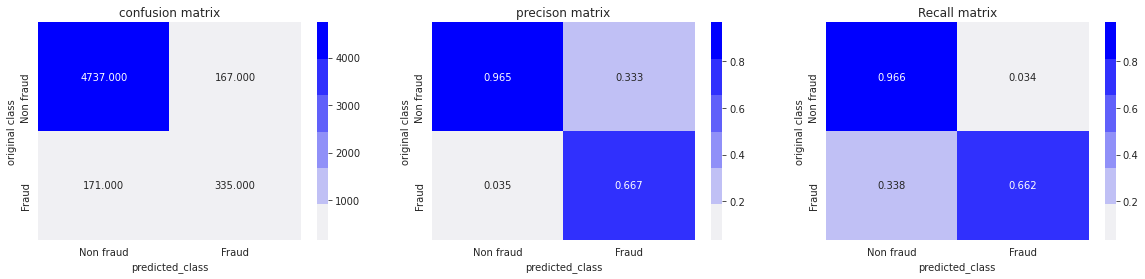

0.6646825396825398

In [11]:
performance(Paths,target)